In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'
    
    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)
    
    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'
        
    js_f_name = f'code_toggle_{random.randint(1,2**64)}'
        
    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}
            
            {js_hide_current}
        </script>
        
        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )
    
    return HTML(html)

hide_toggle()

# PyCon 2018: Ian Ozsvald - On diagramatic diagnosis of data

# Google facets - know your data

At https://pair-code.github.io/facets/

*Facets contains two robust visualizations to aid in understanding and analyzing machine learning datasets. Get a sense of the shape of each feature of your dataset using Facets Overview, or explore individual observations using Facets Dive.*

Offers two tools: **Overview** and **Dive**.

### Facets Overview
    
![](pics/facets-overview.png)

### Facets Dive

![](pics/facets-dive.png)

# Pandas profiling

* a Python package
* `pip install pandas-profiling`

In [13]:
import wget
import pandas as pd
url = 'http://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
fname_titanic = wget.download(url)
df = pd.read_csv(fname_titanic, encoding='UTF-8')

import pandas_profiling as pdp
report = pdp.ProfileReport(df); 

In [14]:
report

Number of variables,8
Number of observations,887
Total Missing (%),0.0%
Total size in memory,55.5 KiB
Average record size in memory,64.1 B
Numeric,5
Categorical,1
Boolean,1
Date,0
Text (Unique),1
Rejected,0


# Missingno library

In [15]:
import missingno as msno
%matplotlib inline

In [16]:
df = pd.read_csv('data/comsur_sample_proc.csv')
df.head()

,uid,house_unit,person_number,area_code,state,age,citiz_status,worker_class,self_care_difc,hearing_difc,...,degree,industry,time_arr_wrk,time_dep_wrk,lang,place_of_birth,race,soc_code,has_insurance,moved_state
0,389879,959600,5,1905,california,13,born_in_the_us,NaN,no,no,...,NaN,NaN,NaN,NaN,hmong,california,asian_alone,NaN,no,False
1,140444,979547,2,800,arkansas,16,born_in_the_us,NaN,no,no,...,NaN,NaN,NaN,NaN,NaN,arkansas,white_alone,NaN,no,False
2,341082,761384,1,6510,california,63,born_in_the_us,emp_private,no,no,...,NaN,fin,12.333333,9.0,NaN,california,white_alone,sal,no,False
3,617625,1180762,1,101,delaware,76,born_in_the_us,emp_private,no,no,...,NaN,mfg,NaN,NaN,NaN,tennessee,black_or_african_ame,cln,no,True
4,881358,996647,4,3400,georgia,12,born_in_the_us,NaN,no,no,...,NaN,NaN,NaN,NaN,NaN,georgia,white_alone,NaN,no,False


### Data completion display

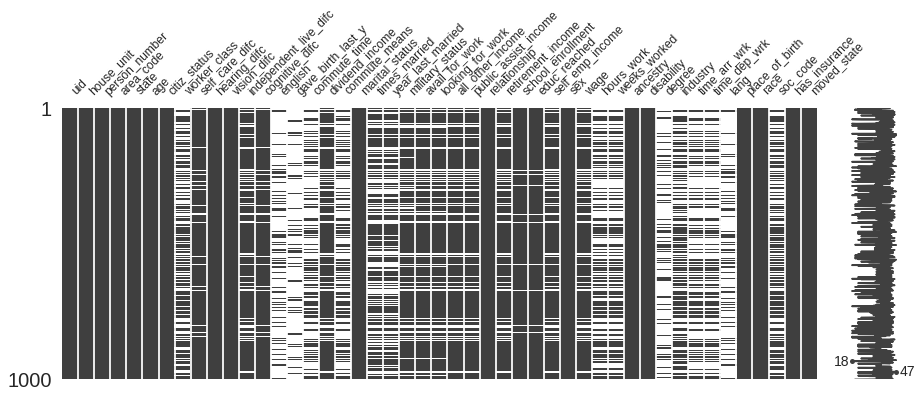

In [6]:
msno.matrix(df, figsize=(15, 5), fontsize=12)

### Bar chart

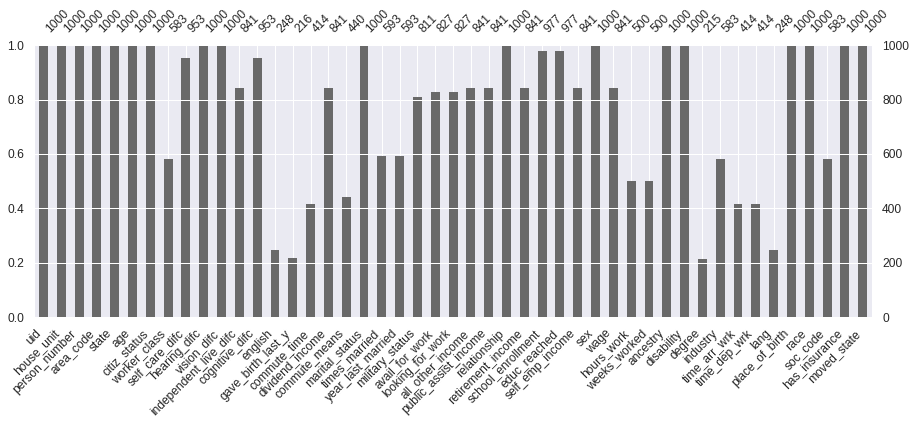

In [7]:
msno.bar(df, figsize=(15, 5), fontsize=12)

### How much presence of one variable correlates with presence of another variable

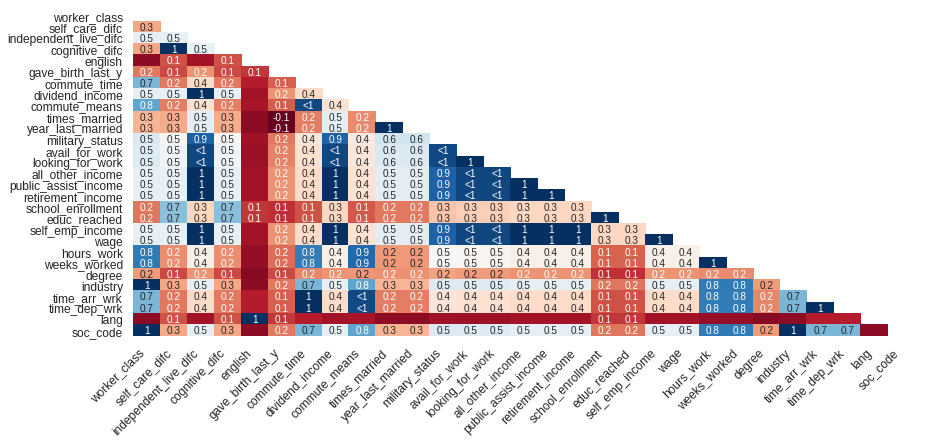

In [8]:
msno.heatmap(df, figsize=(14, 6), fontsize=12)  # measures nullity correlation

# Discover feature relationships

Library developed by Ian

Discovers "feature relationships" - which feature has predicting power

https://github.com/ianozsvald/discover_feature_relationships (you need to clone this repo in the working directory to make the code work)

### How it works

https://github.com/ianozsvald/discover_feature_relationships/blob/master/discover.py

```python
for col in cols:
    if col in classifier_overrides:
        est = RandomForestClassifier(n_estimators=50)
    else:
        est = RandomForestRegressor(n_estimators=50)
    estimator_mapping[col] = est
```

```python
if method=="rf":
    # cross validation
    scores = cross_val_score(est, df_X, df_y, cv=3)#, n_jobs=-1)
    score = scores.mean()
    #score = max(score, 0.0) # set negative r^2 to 0
```

### Let's try

In [17]:
import discover_feature_relationships.discover as disc
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv(fname_titanic)
df.head() 

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


### Discover the relationships

In [19]:
cont_cols = ['Age', 'Fare', 'Pclass', 'Siblings/Spouses Aboard']
cat_cols = ['Survived', 'Sex']

df_results = disc.discover(df[cont_cols + cat_cols].sample(frac=1), 
                           classifier_overrides=cat_cols)
df_results.head()

,feature,score,target
0,Fare,0.007164,Age
1,Pclass,0.149957,Age
2,Siblings/Spouses Aboard,0.108903,Age
3,Survived,-0.001965,Age
4,Sex,-0.000839,Age


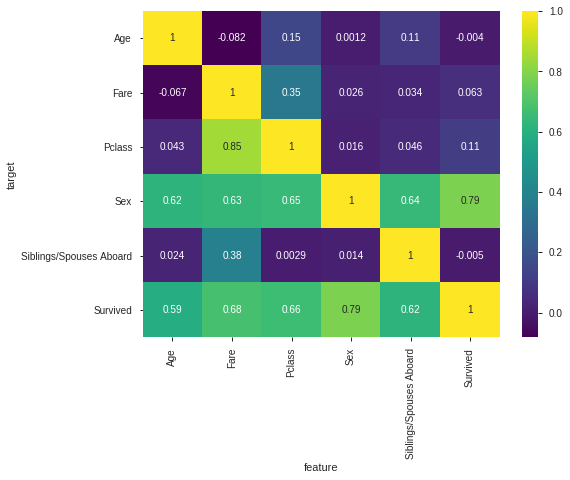

In [12]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_results.pivot(index='target', columns='feature', values='score').fillna(1), 
            annot=True, ax=ax, cmap="viridis");